## Project notebook

Using tensorflow and keras wrapper

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import utils
import models
import h5py
from PIL import Image
from pylab import savefig

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import merge
from keras.optimizers import SGD, Adadelta, Adam, RMSprop
from keras.utils import np_utils
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Load training data

In [2]:
X_train, y_train, meanImage, labels = utils.load_training_data();

num_classes = len(labels);


X_train shape: (100000, 64, 64, 3)
y_train shape: (100000,)


(-0.5, 63.5, 63.5, -0.5)

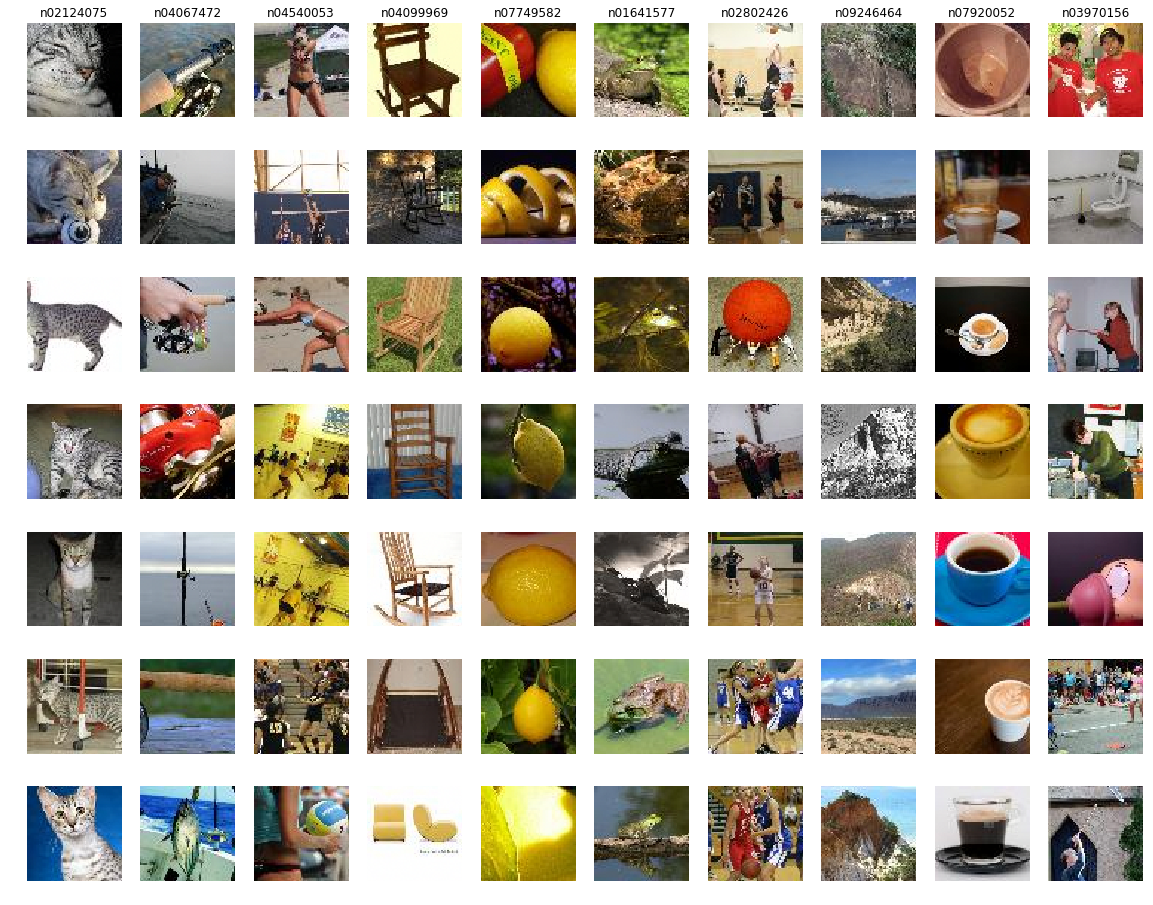

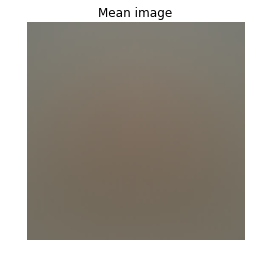

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.   
classes = labels[0:10];
num_classes = len(classes);
samples_per_class = 7;
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((128*X_train[idx] + meanImage).astype('uint8'), interpolation="nearest")
        plt.axis('off')
        if i == 0:
            plt.title(cls)

# mean image
plt.figure(figsize = (5,4));
plt.imshow(meanImage.astype('uint8'), interpolation="nearest")
plt.title('Mean image')
plt.axis('off')

## Load validation data

In [4]:
X_val, y_val = utils.load_validation_data(labels, meanImage);

X_val shape: (10000, 64, 64, 3)
y_val shape: (10000,)


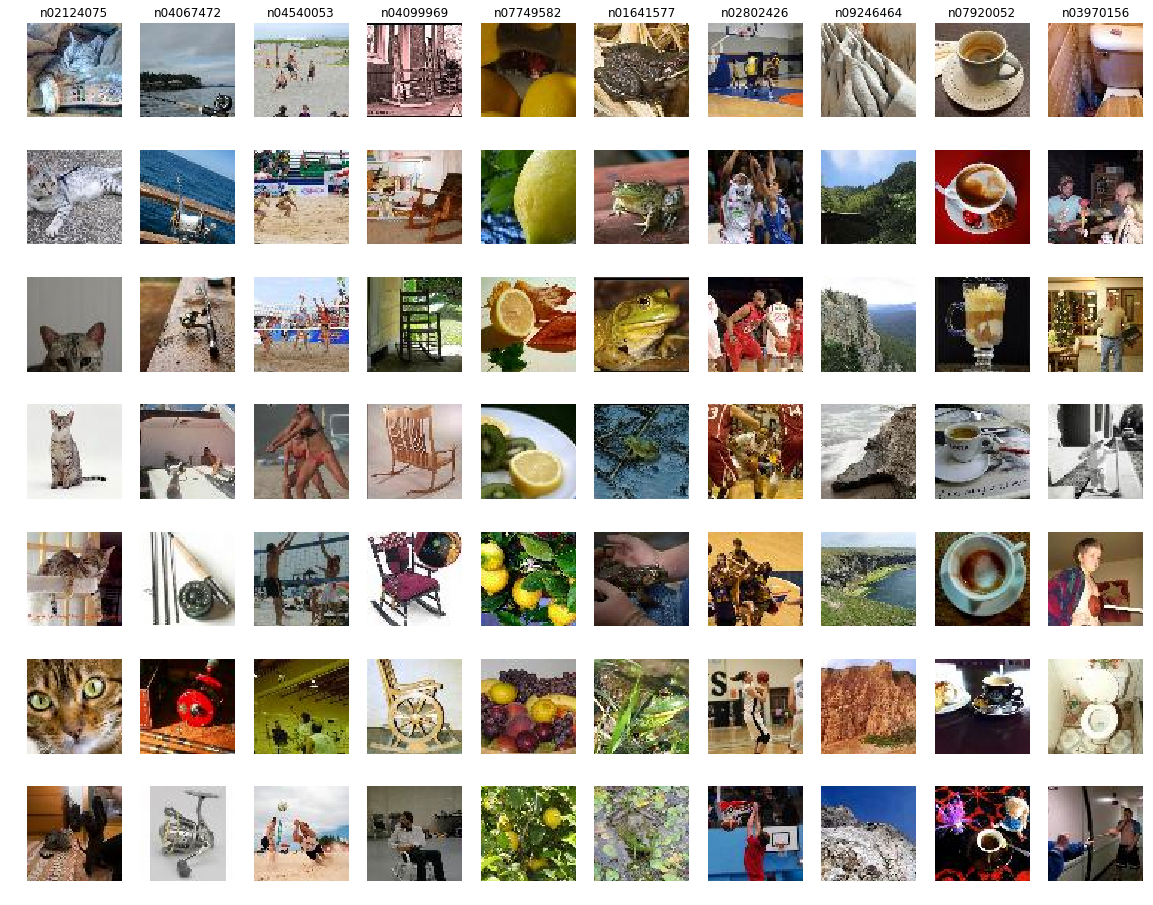

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
plt.figure();
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_val == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((128*X_val[idx] + meanImage).astype('uint8'), interpolation="nearest")
        plt.axis('off')
        if i == 0:
            plt.title(cls)


## Crop data

In [6]:
crop = 4;
X_train = utils.crop_image(X_train, crop, crop)
X_val = utils.crop_image(X_val, crop, crop)

## Transfer learning

In [7]:
model_name = 'modified_VGG16_test'
#weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' 
weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels.h5'

# Show weights in file
f = h5py.File(weights_path)
print([key for key in f.keys()]);

# Create model
model = models.modified_VGG16(input_shape=(64-2*crop, 64-2*crop, 3), drop_rate=0.5, reg=1e-3);
#model = models.modified_ResNet50(input_shape=(64-2*crop, 64-2*crop, 3), reg=1e-4);
       
# Load model weights from file. Only weights with existing names are loaded
model.load_weights(weights_path, by_name=True)

# Only train fully connected layers
for i, layer in enumerate(model.layers):
    if layer.__class__.__name__ != 'Dense':
        model.layers[i].trainable = False;
       
# Show summary
model.summary()

# Train and evaluate
opt = Adam(lr=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

y_train_categorical = np_utils.to_categorical(y_train, num_classes=200);
y_val_categorical = np_utils.to_categorical(y_val, num_classes=200);


['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'fc1', 'fc2', 'flatten', 'predictions']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Co

In [ ]:
## Without data agumentation
history = model.fit(X_train, y_train_categorical, batch_size=200, epochs=10, validation_data=(X_val, y_val_categorical), verbose=True)
metrics = model.evaluate(X_val, y_val_categorical, verbose=True)



Train on 100000 samples, validate on 10000 samples
Epoch 1/10
  7200/100000 [=>............................] - ETA: 281s - loss: 14.0203 - acc: 0.0237

In [ ]:
# With data agumentation
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, y_train_categorical, batch_size=200), steps_per_epoch=len(X_train)/200, epochs=10, validation_data=(X_val, y_val_categorical), verbose=True)
metrics = model.evaluate(X_val, y_val_categorical, verbose=True)

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
savefig(model_name + '_accuracy.png', bbox_inches='tight')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
savefig(model_name + '_loss.png', bbox_inches='tight')

model.save(model_name + '_weights.h5')

utils.save_history(history.history, model_name + '_history.txt')


## Fine tuning

In [ ]:
model_name = 'modified_VGG19_final'
weights_path = model_name + '_weights_finetuned.h5'

# Create model
model = models.modified_VGG19(input_shape=(64-2*crop, 64-2*crop, 3), drop_rate=0.5, reg=1e-5);
#model = models.modified_ResNet50(input_shape=(64-2*crop, 64-2*crop, 3), reg=1e-4);

# Load model weights from file. Only weights with existing names are loaded
model.load_weights(weights_path)

# Train and evaluate
opt = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

y_train_categorical = np_utils.to_categorical(y_train, num_classes=200);
y_val_categorical = np_utils.to_categorical(y_val, num_classes=200);


In [ ]:
# Without data agumentation
history = model.fit(X_train, y_train_categorical, batch_size=200, epochs=20, validation_data=(X_val, y_val_categorical), verbose=True)
metrics = model.evaluate(X_val, y_val_categorical, verbose=True)


In [ ]:
# With data agumentation
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# compute quantities required for featurewisLosse normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
history = model.fit_generator(datagen.flow(X_train, y_train_categorical, batch_size=200), steps_per_epoch=len(X_train)/200, epochs=10, validation_data=(X_val, y_val_categorical), verbose=True)
metrics = model.evaluate(X_val, y_val_categorical, verbose=True)

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
savefig(model_name + '_accuracy_finetuned.jpg', bbox_inches='tight')

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
savefig(model_name + '_loss_finetuned.jpg', bbox_inches='tight')

model.save(model_name + '_weights_finetuned.h5')

utils.save_history(history.history, model_name + '_history_finetuned.txt')

## Run on test set

In [ ]:
# Load test data
X_test, test_files = utils.load_test_data(meanImage);

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
plt.figure();
num_samples = 10;
idxs = np.random.choice(range(len(test_files)), num_samples, replace=False)
for i, idx in enumerate(idxs):
    plt.subplot(1, num_samples, i+1)
    plt.imshow((128*X_test[idx] + meanImage).astype('uint8'), interpolation="nearest")
    plt.axis('off')
    plt.title(test_files[idx])

# Crop
X_test = utils.crop_image(X_test, crop, crop);
    
# Make predictions on test set
probs = model.predict(X_test, batch_size=32, verbose=0);
predictions = np.argmax(probs, axis=1);
print(predictions.shape)

prediceted_classes = [];
for y in predictions:
    prediceted_classes.append(labels[y]);

# Save predictions
utils.save_test_predictions(model_name + '_test_predictions.txt', test_files, prediceted_classes)

In [ ]:
## Predictions on training set
model.evaluate(X_train, y_train_categorical, verbose=True)

## Ensemble

In [ ]:
# Create model
model_VGG16 = models.modified_VGG16(input_shape=(64-2*crop, 64-2*crop, 3), drop_rate=0.5, reg=1e-5);
model_VGG19 = models.modified_VGG19(input_shape=(64-2*crop, 64-2*crop, 3), drop_rate=0.5, reg=1e-5);
model_ResNet50 = model = models.modified_ResNet50(input_shape=(64-2*crop, 64-2*crop, 3), reg=1e-4);
       
# Load model weights from file. Only weights with existing names are loaded
model_VGG16.load_weights('modified_VGG16_final_weights_finetuned.h5')
model_VGG19.load_weights('modified_VGG19_final_weights_finetuned.h5')
model_ResNet50.load_weights('modified_ResNet_final_weights_finetuned.h5')

# Evaluate ensemble
probs_VGG16_train = model_VGG16.predict(X_train, batch_size=32, verbose=True);
probs_VGG19_train = model_VGG19.predict(X_train, batch_size=32, verbose=True);
probs_ResNet50_train = model_ResNet50.predict(X_train, batch_size=32, verbose=True);

probs_VGG16_val = model_VGG16.predict(X_val, batch_size=32, verbose=True);
probs_VGG19_val = model_VGG19.predict(X_val, batch_size=32, verbose=True);
probs_ResNet50_val = model_ResNet50.predict(X_val, batch_size=32, verbose=True);

probs_VGG16_test = model_VGG16.predict(X_test, batch_size=32, verbose=True);
probs_VGG19_test = model_VGG19.predict(X_test, batch_size=32, verbose=True);
probs_ResNet50_test = model_ResNet50.predict(X_test, batch_size=32, verbose=True);

predictions_train = np.argmax(probs_VGG16_train + probs_VGG19_train + probs_ResNet50_train, axis=1);
predictions_val = np.argmax(probs_VGG16_val + probs_VGG19_val + probs_ResNet50_val, axis=1);
predictions_test = np.argmax(probs_VGG16_test + probs_VGG19_test + probs_ResNet50_test, axis=1);

prediceted_classes_train = [];
acc_train = 0;
for i, y in enumerate(predictions_train):
    prediceted_classes_train.append(labels[y]);
    if y == y_train[i]:
        acc_train += 1;
acc_train /= len(predictions_train)
print('acc_train = ', acc_train)
    
prediceted_classes_val = [];
acc_val = 0;
for i, y in enumerate(predictions_val):
    prediceted_classes_val.append(labels[y]);
    if y == y_val[i]:
        acc_val += 1;
acc_val /= len(predictions_val)
print('acc_val = ', acc_val)

prediceted_classes_test = [];
for y in predictions_test:
    prediceted_classes_test.append(labels[y]);

# Save predictions
utils.save_test_predictions('ensemble_test_predictions.txt', test_files, prediceted_classes_test)
